In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pickle
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pprint
import pyedflib

project_root = '..'
sys.path.append(project_root)

from sleeprnn.data.loader import load_dataset, RefactorUnpickler
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection.predicted_dataset import PredictedDataset
from sleeprnn.detection import metrics
from sleeprnn.common import constants, pkeys, checks
from sleeprnn.data import utils

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

RESULTS_PATH = os.path.join(project_root, 'results')
SEED_LIST = [123, 234, 345, 456]

CUSTOM_COLOR = {'red': '#c62828', 'grey': '#455a64', 'blue': '#0277bd', 'green': '#43a047'} 

In [13]:
ckpt_folder = '20190504_bsf'
task_mode = constants.WN_RECORD
dataset_name = constants.MASS_SS_NAME
seed_id = 1
chosen_thr = 0.52
which_expert = 1
verbose = False

dataset = load_dataset(dataset_name)
all_train_ids = dataset.train_ids
test_ids = dataset.test_ids
full_ckpt_folder = '%s_%s_train_%s' % (ckpt_folder, task_mode, dataset_name)
ckpt_path = os.path.abspath(os.path.join(
    RESULTS_PATH,
    'predictions_%s' % dataset_name,
    full_ckpt_folder,
    'bsf',
    'seed%d' % seed_id
))
print('Loading from %s' % ckpt_path)
filename = os.path.join(
    ckpt_path,
    'prediction_%s_%s.pkl' % (task_mode, constants.VAL_SUBSET))
with open(filename, 'rb') as handle:
    prediction_val = RefactorUnpickler(handle).load()  # Predicted Dataset
filename = os.path.join(
    ckpt_path,
    'prediction_%s_%s.pkl' % (task_mode, constants.TEST_SUBSET))
with open(filename, 'rb') as handle:
    prediction_test = RefactorUnpickler(handle).load()  # Predicted Dataset
    
# Validation split
_, val_ids = utils.split_ids_list(
    all_train_ids, seed=SEED_LIST[seed_id], verbose=verbose)
# Prepare expert labels
data_val = FeederDataset(
    dataset, val_ids, task_mode, which_expert=which_expert)
data_test = FeederDataset(
    dataset, test_ids, task_mode, which_expert=which_expert)

# Prepare model predictions
prediction_val.set_probability_threshold(chosen_thr)
prediction_test.set_probability_threshold(chosen_thr)

print('Val IDs:', data_val.get_ids(), prediction_val.get_ids())
print('Test IDs:', data_test.get_ids(), prediction_test.get_ids())

val_ids = data_val.get_ids()
test_ids = data_test.get_ids()

# Get stamps
events_val = data_val.get_stamps()
detections_val = prediction_val.get_stamps()

events_test = data_test.get_stamps()
detections_test = prediction_test.get_stamps()

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Loading from /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20190504_bsf_wn_train_mass_ss/bsf/seed1
Val IDs: [3, 9, 17] [3, 9, 17]
Test IDs: [2, 6, 12, 13] [2, 6, 12, 13]



Subject ID 3
Number of events 533
Number of detections 513
Number of matched 416
Number of UFP 97, Number of UFN 117
Recall at IoU 0.0: 0.7804878048780488
Precision at IoU 0.0: 0.8109161793372319
F1score at IoU 0.0: 0.7954110898661568
F1score at IoU 0.3: 0.7839388145315488
Pages of UFP: [ 107  114  115  120  138  148  158  158  158  165  165  171  173  176
  179  182  182  182  184  184  185  186  188  195  311  321  338  340
  346  346  346  347  362  375  383  384  387  387  389  390  510  511
  518  518  527  528  529  531  538  540  546  560  573  573  576  580
  583  589  589  592  600  626  648  657  674  675  675  677  678  685
  685  688  688  835  842  855  879  887  949  952  960  961  967  967
  973  975  982  982  986  988  988  989  989  989 1010 1016 1022 1023
 1024 1028 1032 1033 1042 1045 1054 1094 1231 1286 1379 1415 1426 1427
 1436 1437]

Loading states
Hypnogram size (1839,)
Pages states unique values: ['1' '2' '3' '4' '?' 'R' 'W']


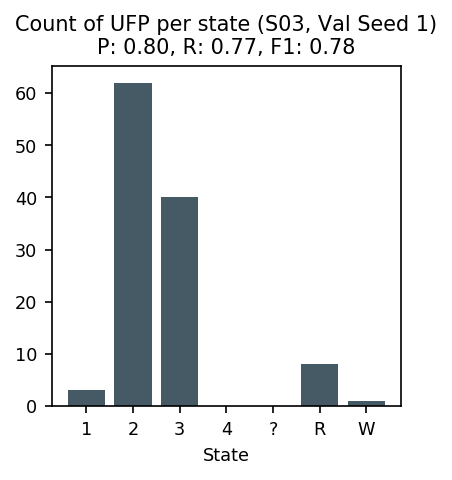

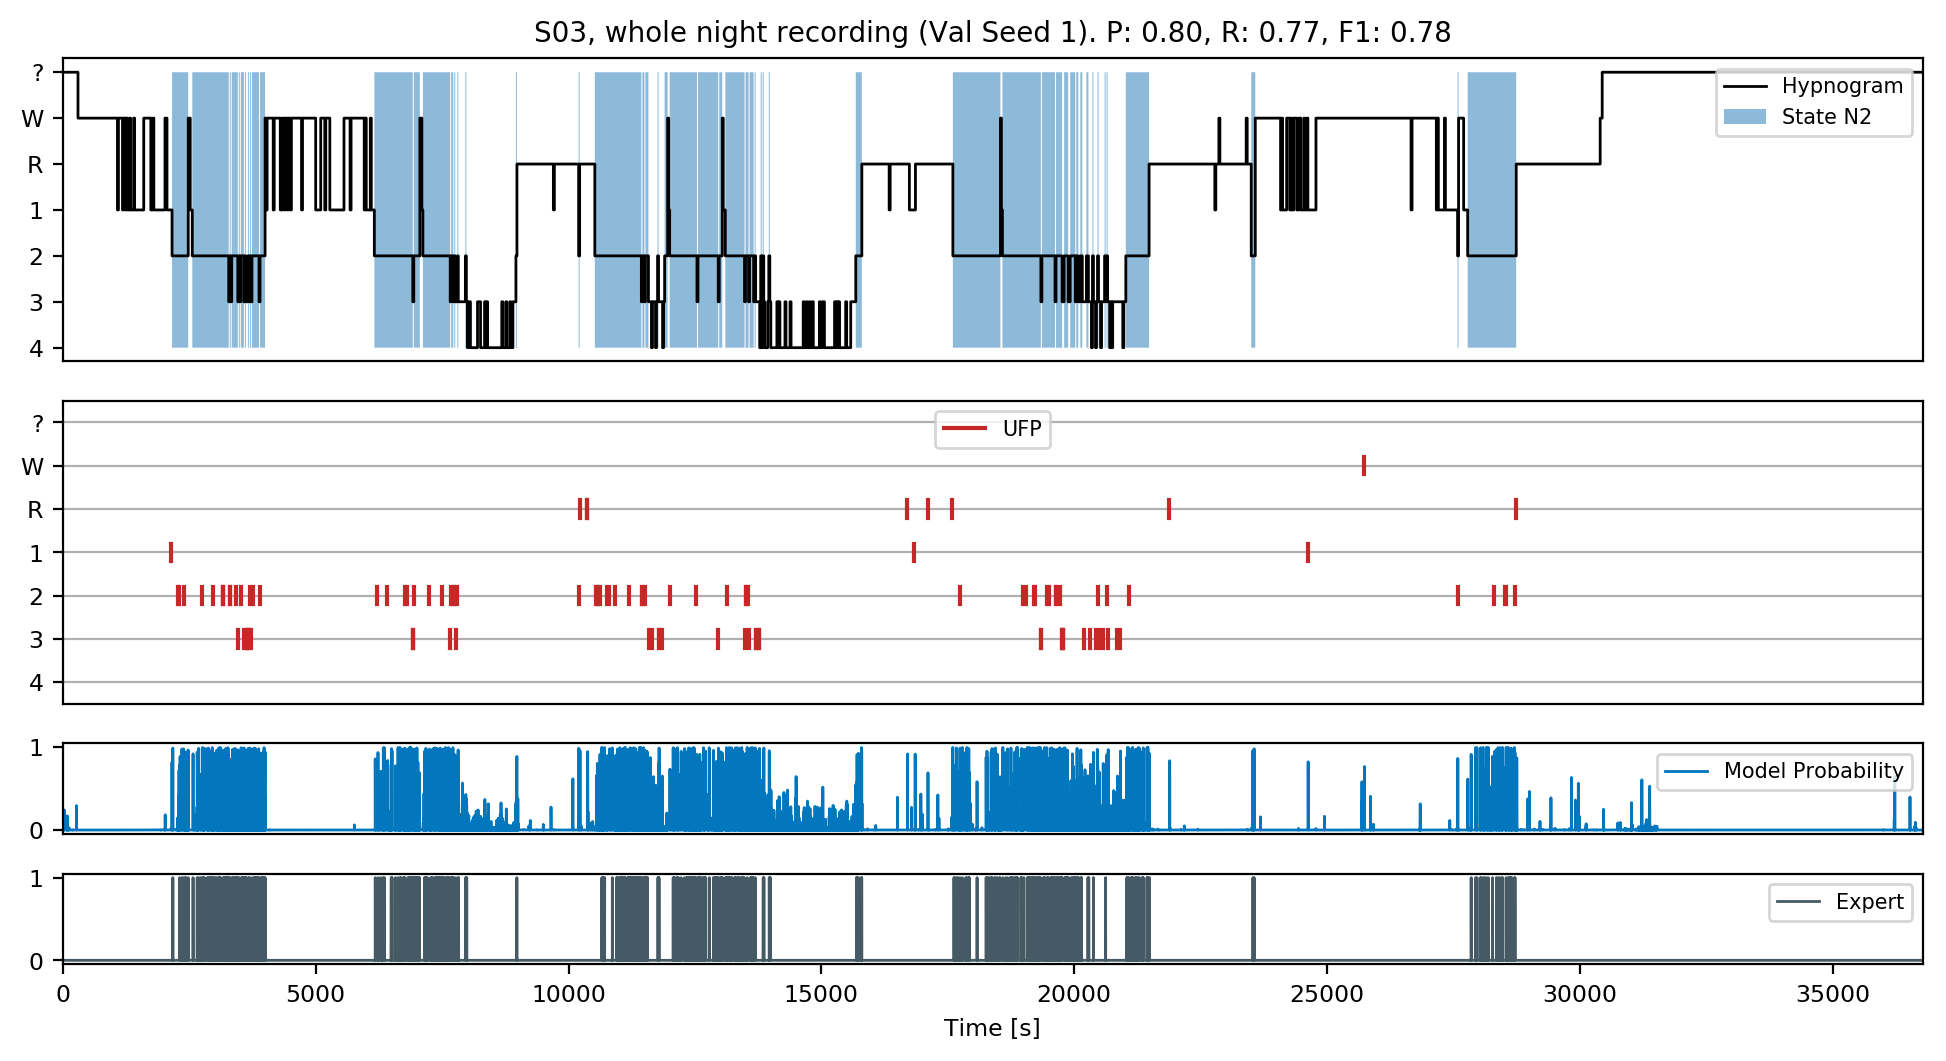


Subject ID 9
Number of events 895
Number of detections 750
Number of matched 665
Number of UFP 85, Number of UFN 230
Recall at IoU 0.0: 0.7430167597765364
Precision at IoU 0.0: 0.8866666666666667
F1score at IoU 0.0: 0.8085106382978723
F1score at IoU 0.3: 0.7975683890577507
Pages of UFP: [ 115  125  139  165  166  180  196  208  210  216  245  282  283  283
  288  289  299  300  300  307  307  307  316  317  320  320  321  407
  437  437  453  466  469  480  481  499  500  514  516  532  532  532
  532  540  549  549  567  593  671  676  677  678  684  713  713  716
  718  745  765  768  779  802  804  811  820  820  820  821  822  826
  831  834  844  854  868  868  868  869  869  870  873  874  892  897
  902  922  922  923  928  930  930  930  930  931  993  993 1005 1005
 1007 1023 1057 1131 1135 1167 1182 1191 1196 1221 1289 1352 1381 1385]

Loading states
Hypnogram size (1492,)
Pages states unique values: ['1' '2' '3' '4' '?' 'R' 'W']


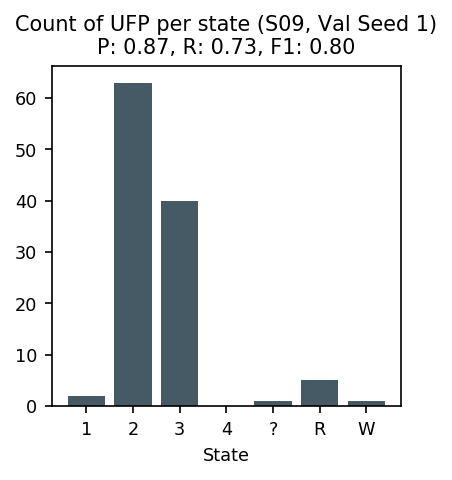

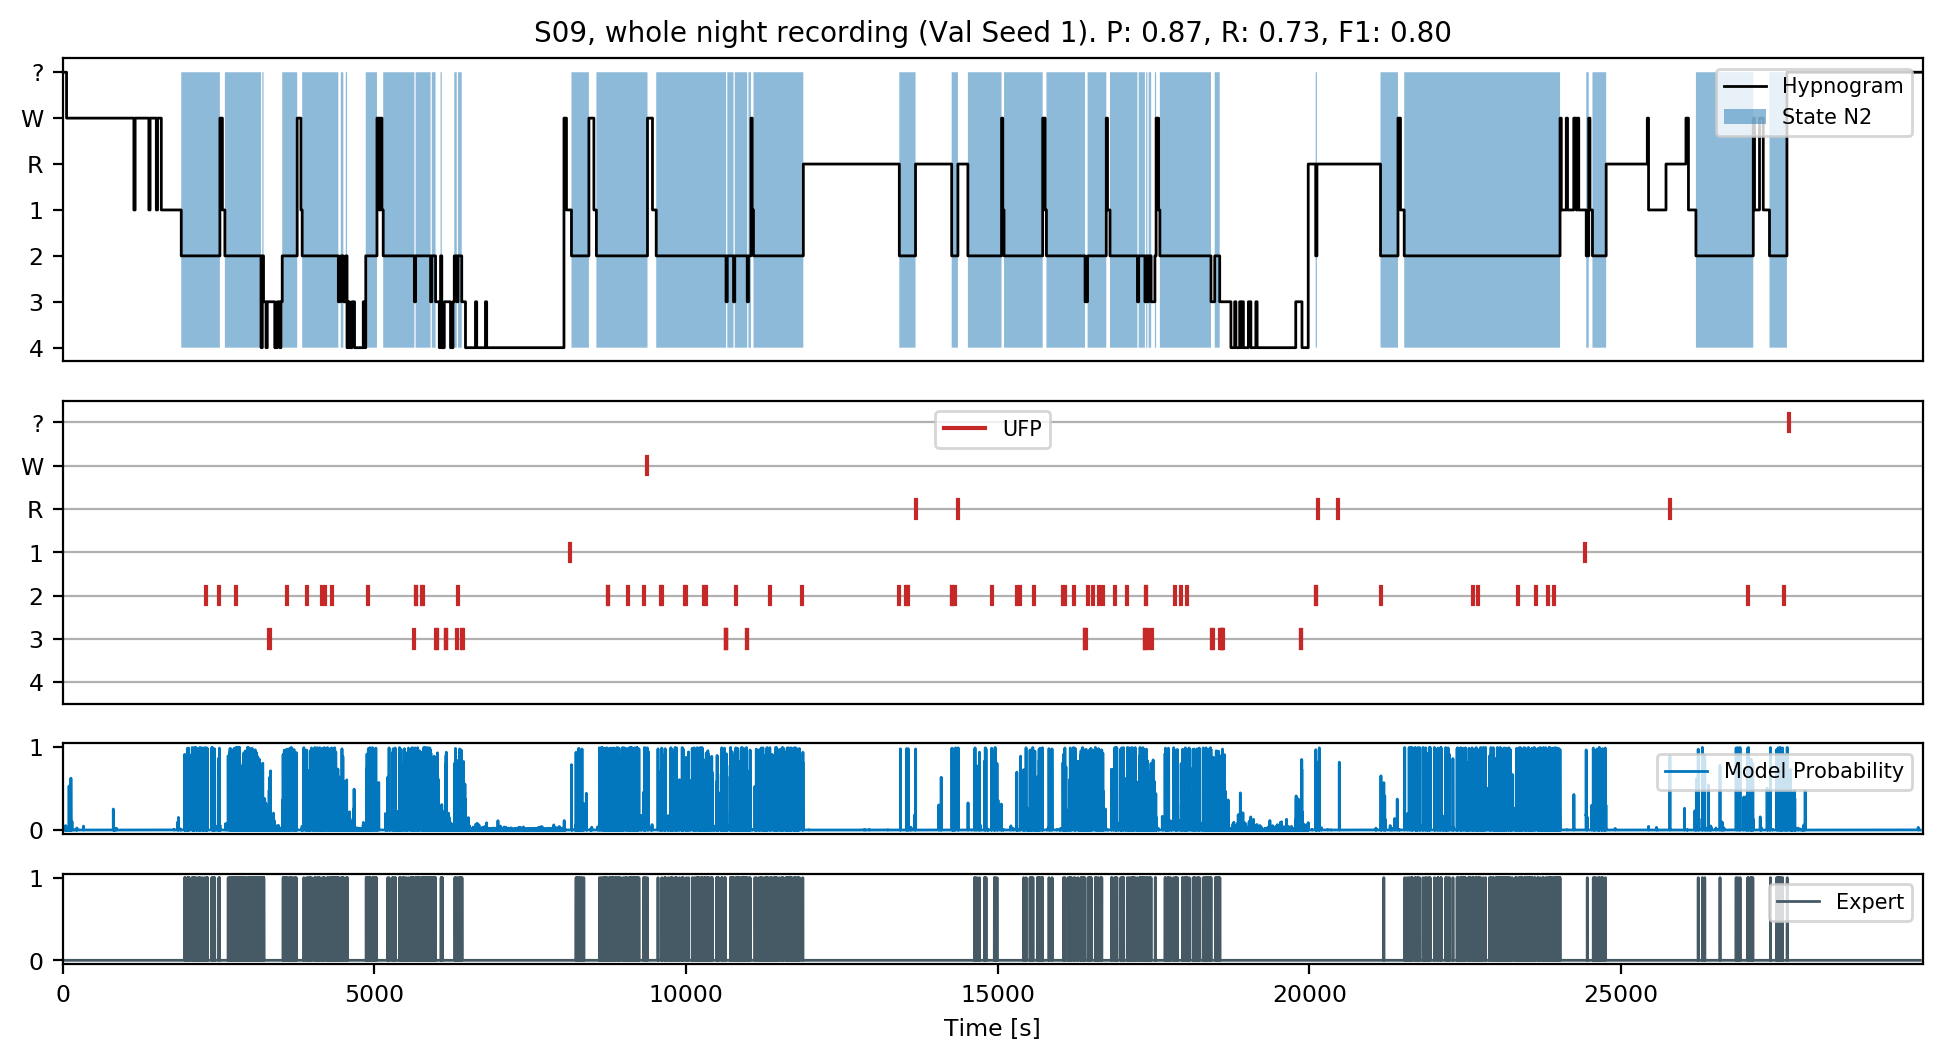


Subject ID 17
Number of events 595
Number of detections 576
Number of matched 406
Number of UFP 170, Number of UFN 189
Recall at IoU 0.0: 0.6823529411764706
Precision at IoU 0.0: 0.7048611111111112
F1score at IoU 0.0: 0.6934244235695987
F1score at IoU 0.3: 0.6883005977796754
Pages of UFP: [  14   20   38   45   47   47   48   53   72  100  109  111  111  114
  114  115  116  122  123  128  128  129  158  159  173  174  214  220
  222  225  235  295  304  307  307  308  313  318  329  329  329  337
  347  364  373  383  408  422  438  446  450  455  456  459  475  478
  487  491  497  517  520  524  527  531  541  542  542  548  566  569
  569  573  575  579  580  584  585  585  592  594  597  598  618  623
  644  655  659  672  685  711  714  714  720  723  726  728  731  732
  752  763  776  793  803  803  807  817  820  820  825  828  845  845
  847  852  852  856  862  863  882  885  888  893  908  917  922  925
  925  931  934  936  951  954  963  997 1012 1020 1034 1037 1046 1052

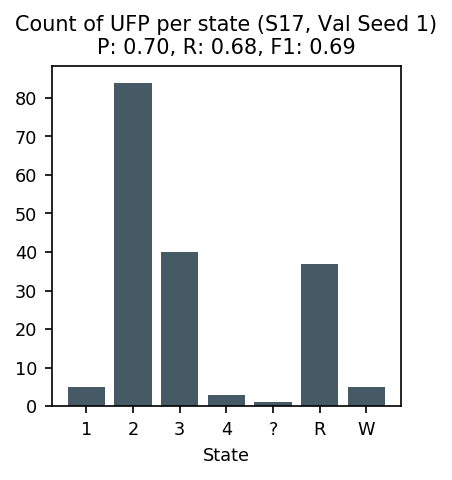

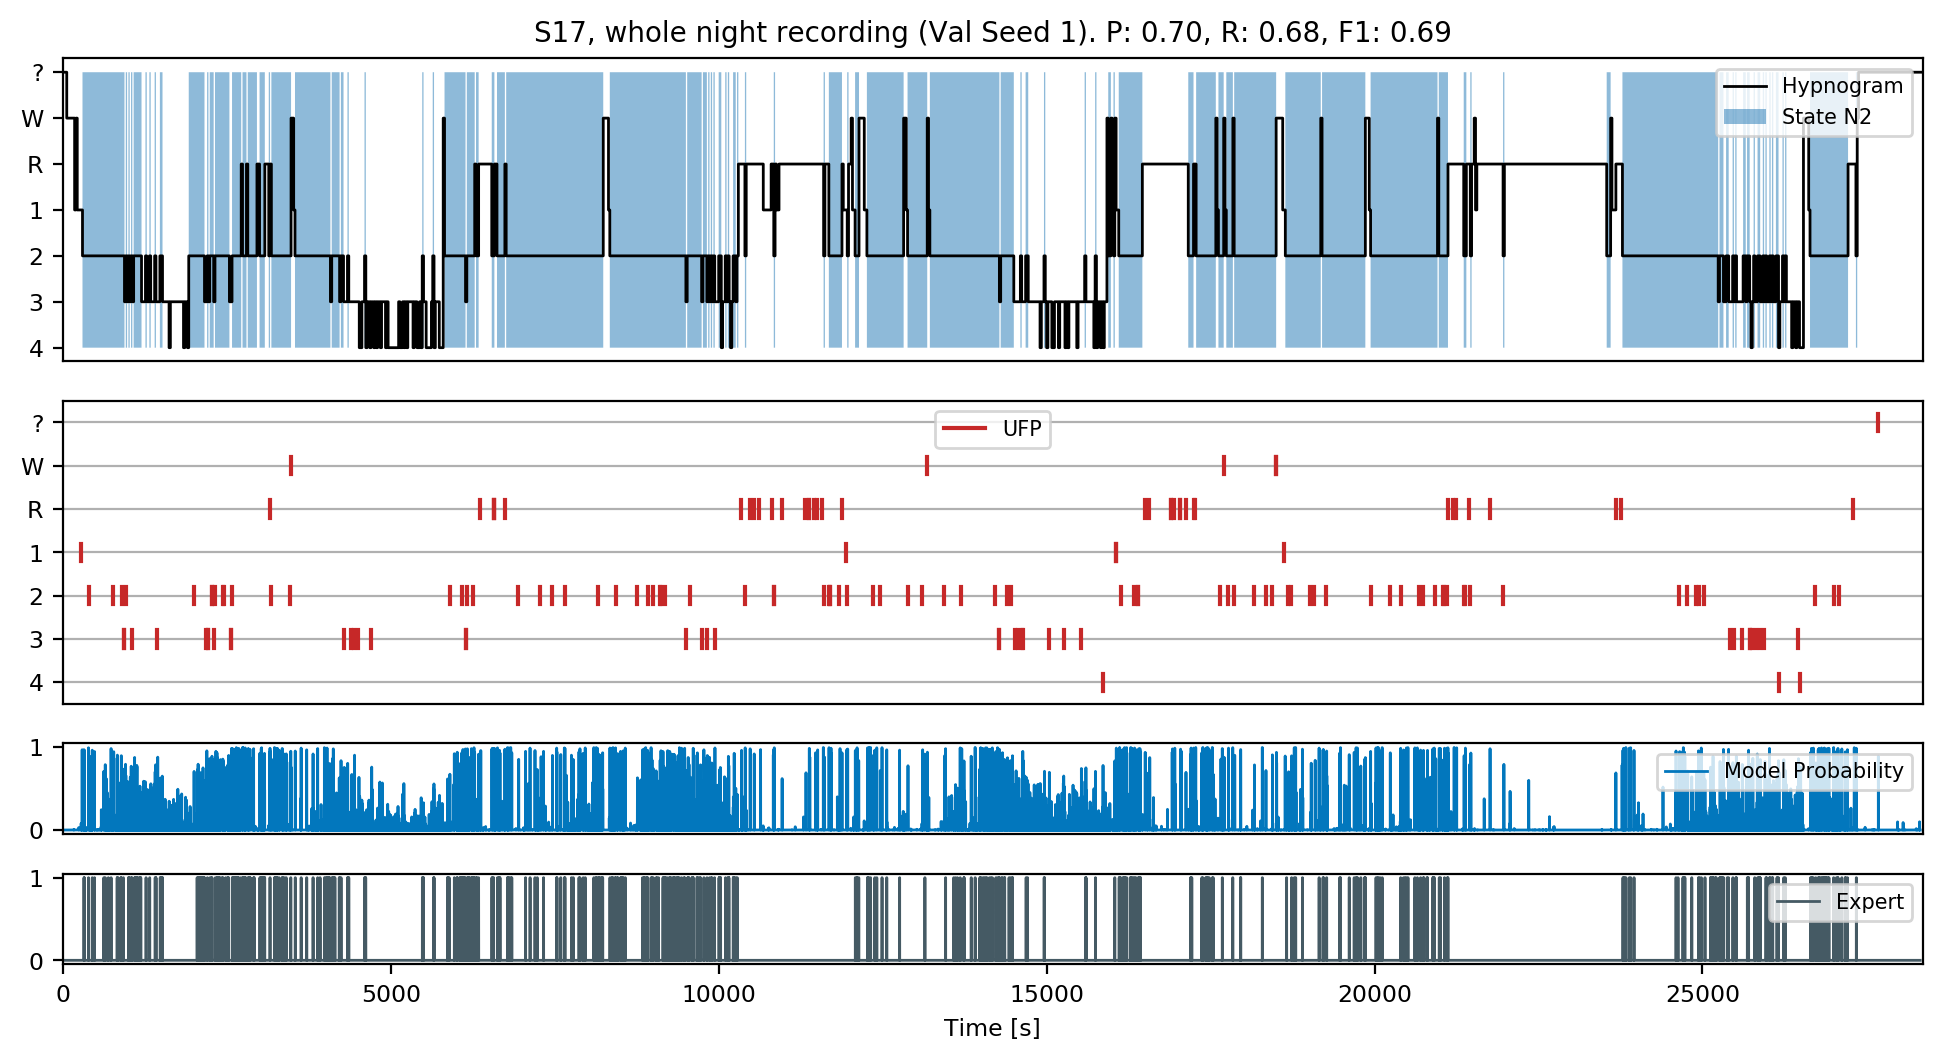

In [7]:
for sub_idx in range(len(val_ids)):

    subject_id = val_ids[sub_idx]
    print('\nSubject ID', subject_id)
    events = events_val[sub_idx]
    detections = detections_val[sub_idx]
    iou_array, idx_array = metrics.matching(events, detections)
    n_detections = detections.shape[0]
    n_events = events.shape[0]
    n_ufn = (idx_array == -1).sum()
    n_matched = n_events - n_ufn
    n_ufp = n_detections - n_matched
    n_matched_at_03 = (iou_array >= 0.3).sum()
    f1_at_03 = 2 * n_matched_at_03 / (n_events + n_detections)
    p_at_03 = n_matched_at_03 / n_detections
    r_at_03 = n_matched_at_03 / n_events
    print('Number of events', n_events)
    print('Number of detections', n_detections)
    print('Number of matched', n_matched)
    print('Number of UFP %d, Number of UFN %d' % (n_ufp, n_ufn))
    print('Recall at IoU 0.0:', n_matched / n_events)
    print('Precision at IoU 0.0:', n_matched / n_detections)
    print('F1score at IoU 0.0:', 2*n_matched / (n_events + n_detections))
    print('F1score at IoU 0.3:', f1_at_03)

    ufp_idx = [i for i in range(n_detections) if i not in idx_array]
    detections_ufp = detections[ufp_idx, :]
    centers_ufp = np.mean(detections_ufp, axis=1)
    pages_ufp = np.floor(centers_ufp / dataset.page_size).astype(np.int32)
    print('Pages of UFP:', pages_ufp)

    # Read states for subset of pages
    print('\nLoading states')
    numerical_state_values = {
        '1': -1, '2': -2, '3': -3, '4': -4, 'R': 0, 'W': 1, '?': 2
    }
    pages_subset_states = dataset.get_subject_hypnogram(subject_id)
    print('Hypnogram size', pages_subset_states.shape)

    print('Pages states unique values:', np.unique(pages_subset_states))

    # Get state of UFP
    states_ufp = pages_subset_states[pages_ufp]

    fs = dataset.fs
    down_factor = prediction_val.params[pkeys.TOTAL_DOWNSAMPLING_FACTOR]
    fs_proba = fs / down_factor
    
    # Probability
    my_proba = prediction_val.probabilities_dict[subject_id]
    my_proba_time = np.arange(my_proba.shape[0]) / fs_proba

    # Expert stamps
    my_expert = utils.stamp2seq(events, 0, my_proba.shape[0] * down_factor + 1)
    my_expert_time = np.arange(my_expert.shape[0]) / fs


    numerical_state = np.zeros(pages_subset_states.shape)
    state_time = np.arange(pages_subset_states.shape[0]) * dataset.page_duration
    all_state_key_list = dataset.state_ids
    for state_key in all_state_key_list:
        np.place(numerical_state, pages_subset_states==state_key, numerical_state_values[state_key])

    # plot
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
    ax.set_title('Count of UFP per state (S%02d, Val Seed %d)\nP: %1.2f, R: %1.2f, F1: %1.2f' 
                 % (subject_id, seed_id, p_at_03, r_at_03, f1_at_03), fontsize=10)
    unique, counts = np.unique(states_ufp, return_counts=True)
    for state_key in all_state_key_list:
        if state_key not in unique:
            unique = np.concatenate([unique, [state_key]])
            counts = np.concatenate([counts, [0]])
    sorted_idx = np.argsort(unique)
    unique = unique[sorted_idx]
    counts = counts[sorted_idx]
    ax.bar(unique, counts, width=0.8, bottom=None, facecolor=CUSTOM_COLOR['grey'])
    ax.set_xlabel('State', fontsize=8.5)
    ax.tick_params(labelsize=8.5)
    plt.show()

    # plot
    
    fig = plt.figure(figsize=(12, 6), dpi=200)
    gs = gridspec.GridSpec(4, 1, height_ratios=[2, 2, 0.6, 0.6])

    # Hypnogram
    ax = fig.add_subplot(gs[0])
    ax.set_title('S%02d, whole night recording (Val Seed %d). P: %1.2f, R: %1.2f, F1: %1.2f' 
                 % (subject_id, seed_id, p_at_03, r_at_03, f1_at_03), fontsize=10)
    
    tmp_state_time = []
    tmp_numerical_state = []
    for j in range(state_time.shape[0]):
        tmp_numerical_state.append(numerical_state[j])
        tmp_numerical_state.append(numerical_state[j])
        tmp_state_time.append(state_time[j])
        tmp_state_time.append(state_time[j] + dataset.page_duration)
    tmp_state_time = np.asarray(tmp_state_time)
    tmp_numerical_state = np.asarray(tmp_numerical_state)
    
    max_time = np.max([my_expert_time[-1], my_proba_time[-1], tmp_state_time[-1]])

    ax.plot(tmp_state_time, tmp_numerical_state, color='k', zorder=2, linewidth=1, label='Hypnogram')
    ax.fill_between(tmp_state_time, 6 * (tmp_numerical_state==-2).astype(int) - 4, -4, alpha=0.5, zorder=1, label='State N2')
    ax.set_yticks([numerical_state_values[my_key] for my_key in numerical_state_values.keys()])
    ax.set_xlim([0, state_time[-1]])
    ax.set_yticklabels(list(numerical_state_values.keys()))
    ax.legend(loc='upper right', fontsize=7.5)
    ax.set_xticks([])
    ax.set_xlim([0, max_time])
    ax.tick_params(labelsize=8.5)

    # detailed UFP
    ax = fig.add_subplot(gs[1])
    ax.set_ylim([-4.5, 2.5])
    ax.set_xticks([])
    ax.set_xlim([0, max_time])
    ax.set_yticks([numerical_state_values[my_key] for my_key in numerical_state_values.keys()])
    ax.set_yticklabels(list(numerical_state_values.keys()))
    label_set = False
    for j, state_key in enumerate(all_state_key_list):
        for k, page in enumerate(pages_ufp):
            if states_ufp[k] == state_key:
                if label_set:
                    label = None
                else:
                    label = 'UFP'
                label_set = True
                page_time = page * dataset.page_duration
                ax.plot(
                    [page_time, page_time], 
                    [numerical_state_values[state_key] - 0.2, numerical_state_values[state_key] + 0.2], 
                    color=CUSTOM_COLOR['red'], label=label, linewidth=1.5)
    if label_set:
        ax.legend(loc='upper center', fontsize=7.5)
    ax.yaxis.grid()
    ax.tick_params(labelsize=8.5)

    # Model probability
    ax = fig.add_subplot(gs[2])
    ax.plot(my_proba_time, my_proba, label='Model Probability',color=CUSTOM_COLOR['blue'], linewidth=1)
    ax.set_yticks([0, 1])
    ax.legend(loc='upper right', fontsize=7.5)
    ax.set_xticks([])
    ax.set_xlim([0, max_time])
    ax.tick_params(labelsize=8.5)

    # Expert stamps
    ax = fig.add_subplot(gs[3])
    ax.plot(my_expert_time, my_expert, label='Expert',color=CUSTOM_COLOR['grey'], linewidth=1)
    ax.set_yticks([0, 1])
    ax.legend(loc='upper right', fontsize=7.5)
    ax.set_xlim([0, max_time])
    ax.tick_params(labelsize=8.5)
    ax.set_xlabel('Time [s]', fontsize=8.5)

    plt.show()


Subject ID 2
Number of events 1143
Number of detections 1151
Number of matched 942
Number of UFP 209, Number of UFN 201
Recall at IoU 0.0: 0.8241469816272966
Precision at IoU 0.0: 0.8184187662901824
F1score at IoU 0.0: 0.8212728857890148
F1score at IoU 0.3: 0.8195292066259808
Pages of UFP: [  35   42   64   65   69   70   74   74   75   79   80   81   85   90
   93  135  137  142  177  183  184  186  193  278  349  378  415  442
  461  482  488  492  495  511  511  533  544  544  580  592  594  595
  601  602  605  609  610  613  624  632  638  639  640  647  656  657
  659  663  665  691  701  704  715  717  719  724  786  794  803  808
  811  817  820  828  832  839  839  840  862  862  864  866  867  869
  870  882  889  900  904  905  912  917  919  921  926  930  931  936
  943  952  957  968  972  974  976  977  980  987  988 1002 1004 1005
 1007 1096 1098 1100 1102 1106 1111 1119 1125 1125 1132 1132 1138 1139
 1142 1143 1151 1152 1153 1158 1160 1161 1163 1165 1166 1169 1169 117

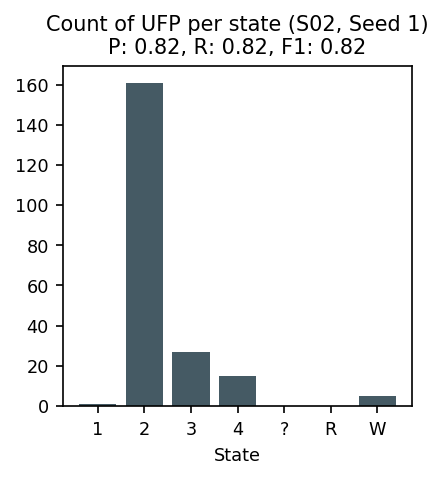

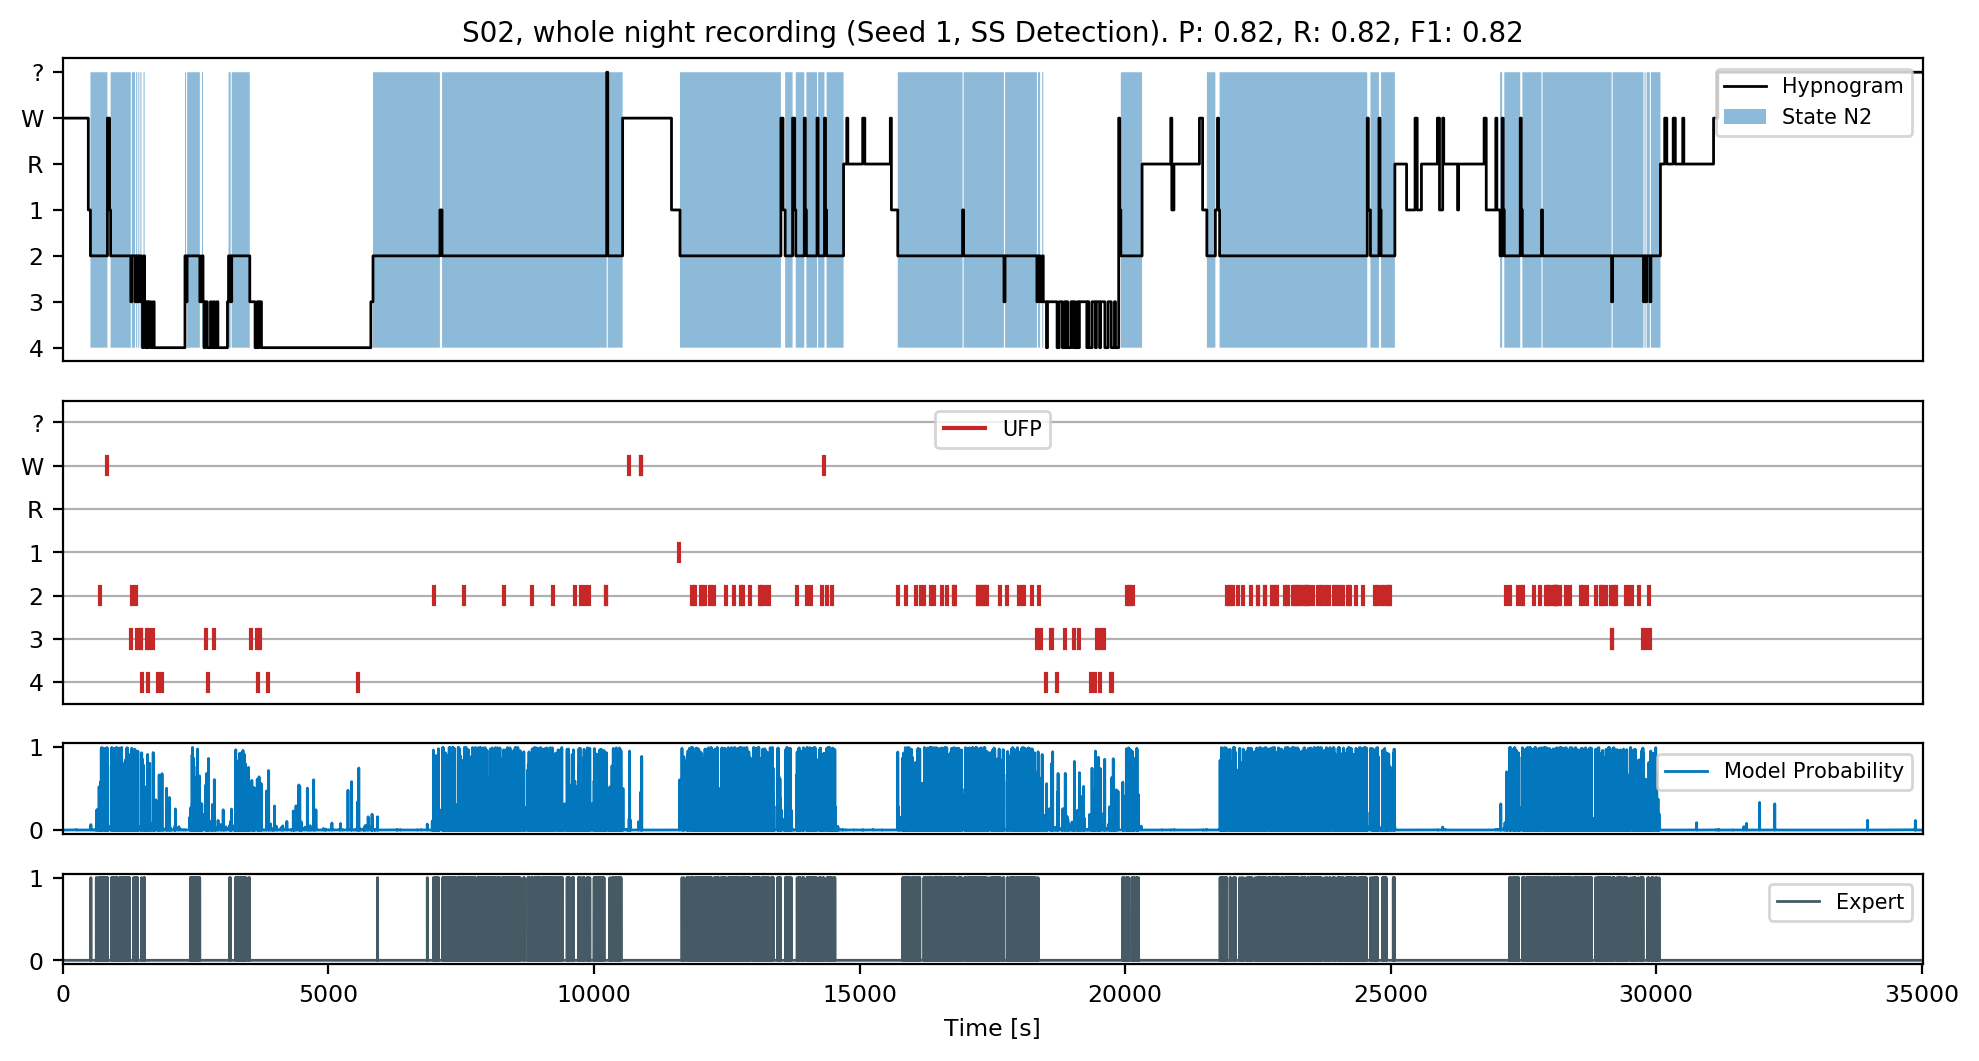


Subject ID 6
Number of events 150
Number of detections 162
Number of matched 115
Number of UFP 47, Number of UFN 35
Recall at IoU 0.0: 0.7666666666666667
Precision at IoU 0.0: 0.7098765432098766
F1score at IoU 0.0: 0.7371794871794872
F1score at IoU 0.3: 0.7371794871794872
Pages of UFP: [  60   79   81   93  238  308  320  441  448  497  509  612  653  686
  695  718  729  746  755  836  859  875  878  899  899  906  915  929
  930  940  956  956  968 1000 1146 1158 1162 1175 1185 1202 1231 1233
 1266 1271 1277 1283 1364]

Loading states
Hypnogram size (1450,)
Pages states unique values: ['1' '2' '3' '4' '?' 'R' 'W']


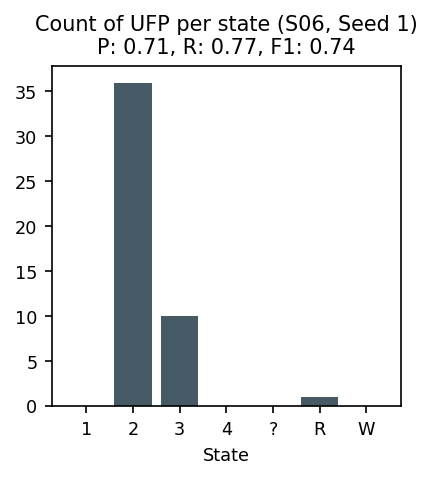

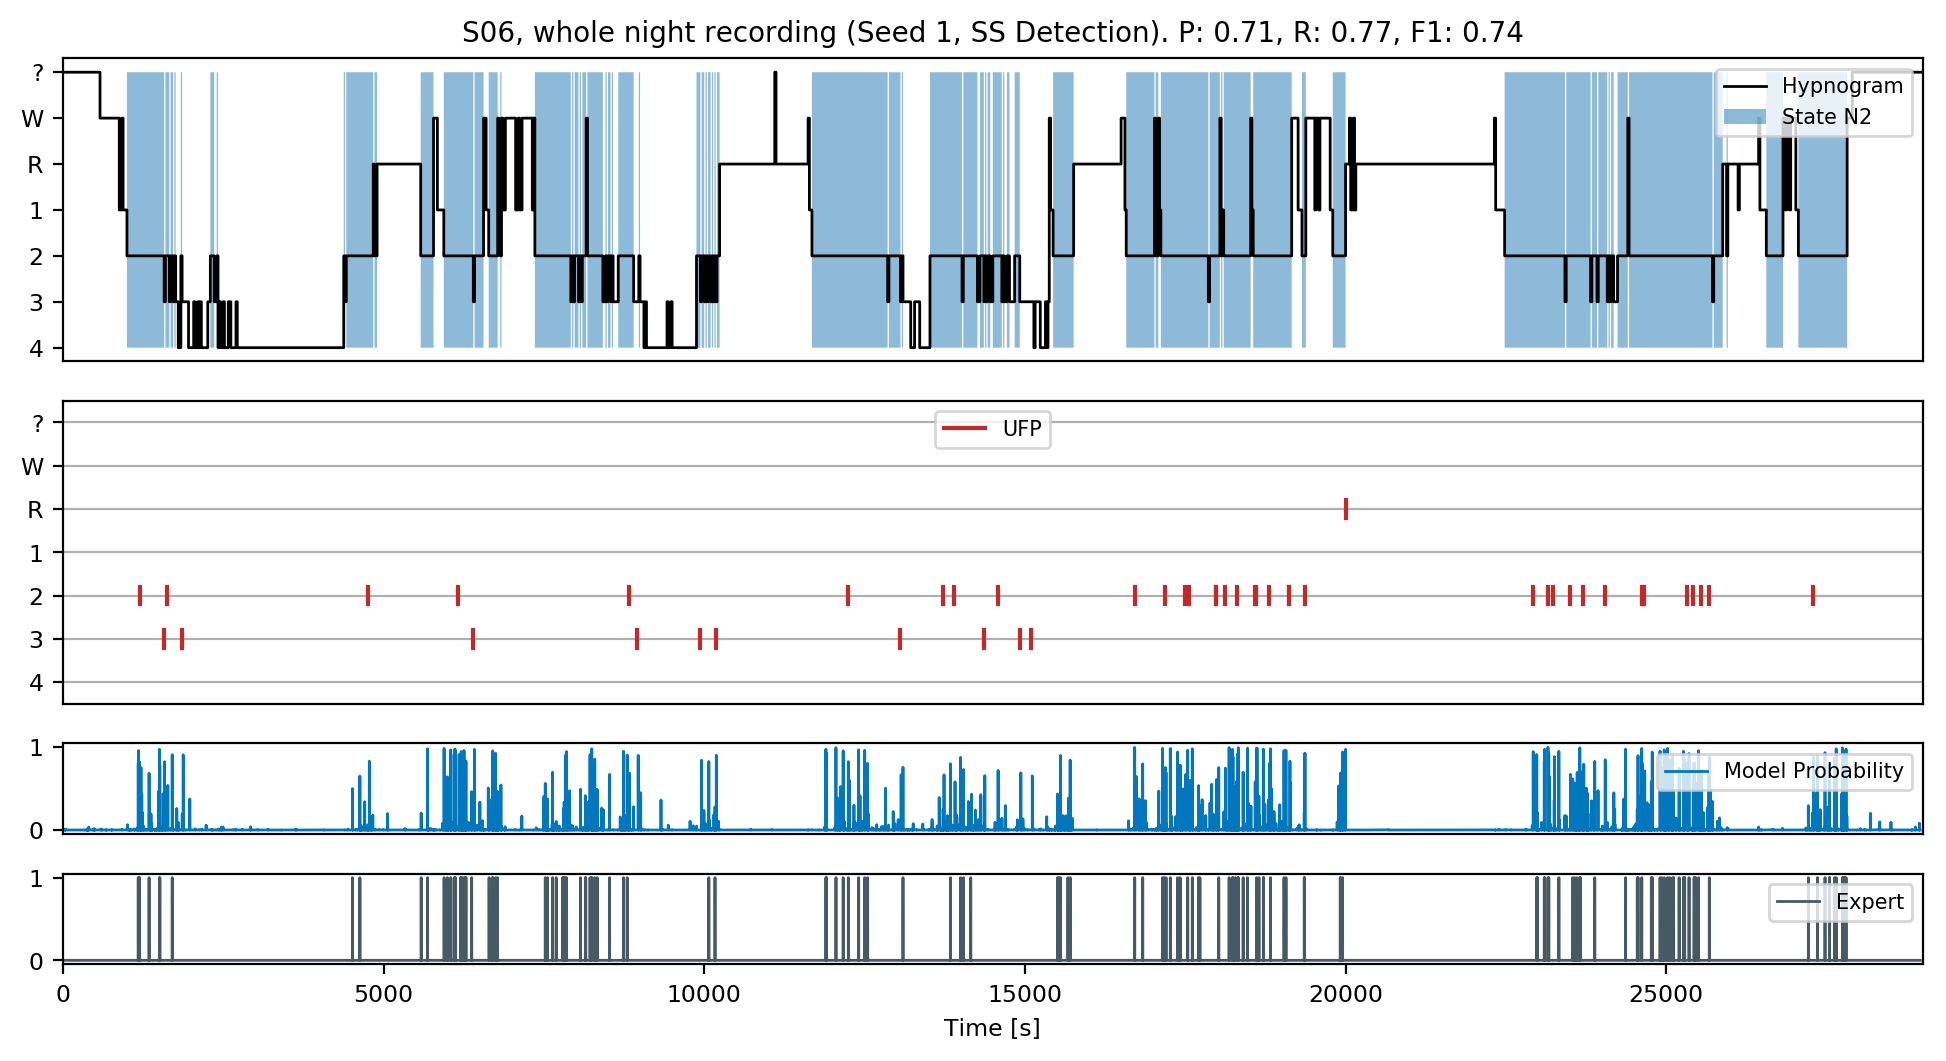


Subject ID 12
Number of events 708
Number of detections 627
Number of matched 511
Number of UFP 116, Number of UFN 197
Recall at IoU 0.0: 0.7217514124293786
Precision at IoU 0.0: 0.8149920255183413
F1score at IoU 0.0: 0.7655430711610487
F1score at IoU 0.3: 0.7655430711610487
Pages of UFP: [  42   51   52   60   61   62   62   65   78   83   84  100  147  148
  150  170  183  185  187  187  187  190  190  193  196  203  212  212
  240  254  258  260  274  283  284  297  299  324  338  346  351  361
  375  377  378  424  449  453  454  454  455  455  460  517  521  543
  544  547  553  583  586  590  603  604  606  624  628  665  667  680
  681  684  747  782  784  799  800  829  837  837  865  874  879  879
  882  882  886  886  890  894  895  922  962  978 1127 1148 1151 1159
 1195 1199 1199 1216 1223 1231 1253 1265 1406 1412 1414 1415 1428 1435
 1467 1471 1477 1497]

Loading states
Hypnogram size (1577,)
Pages states unique values: ['1' '2' '3' '4' '?' 'R' 'W']


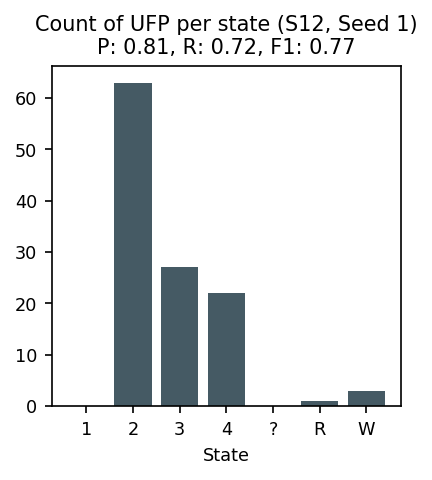

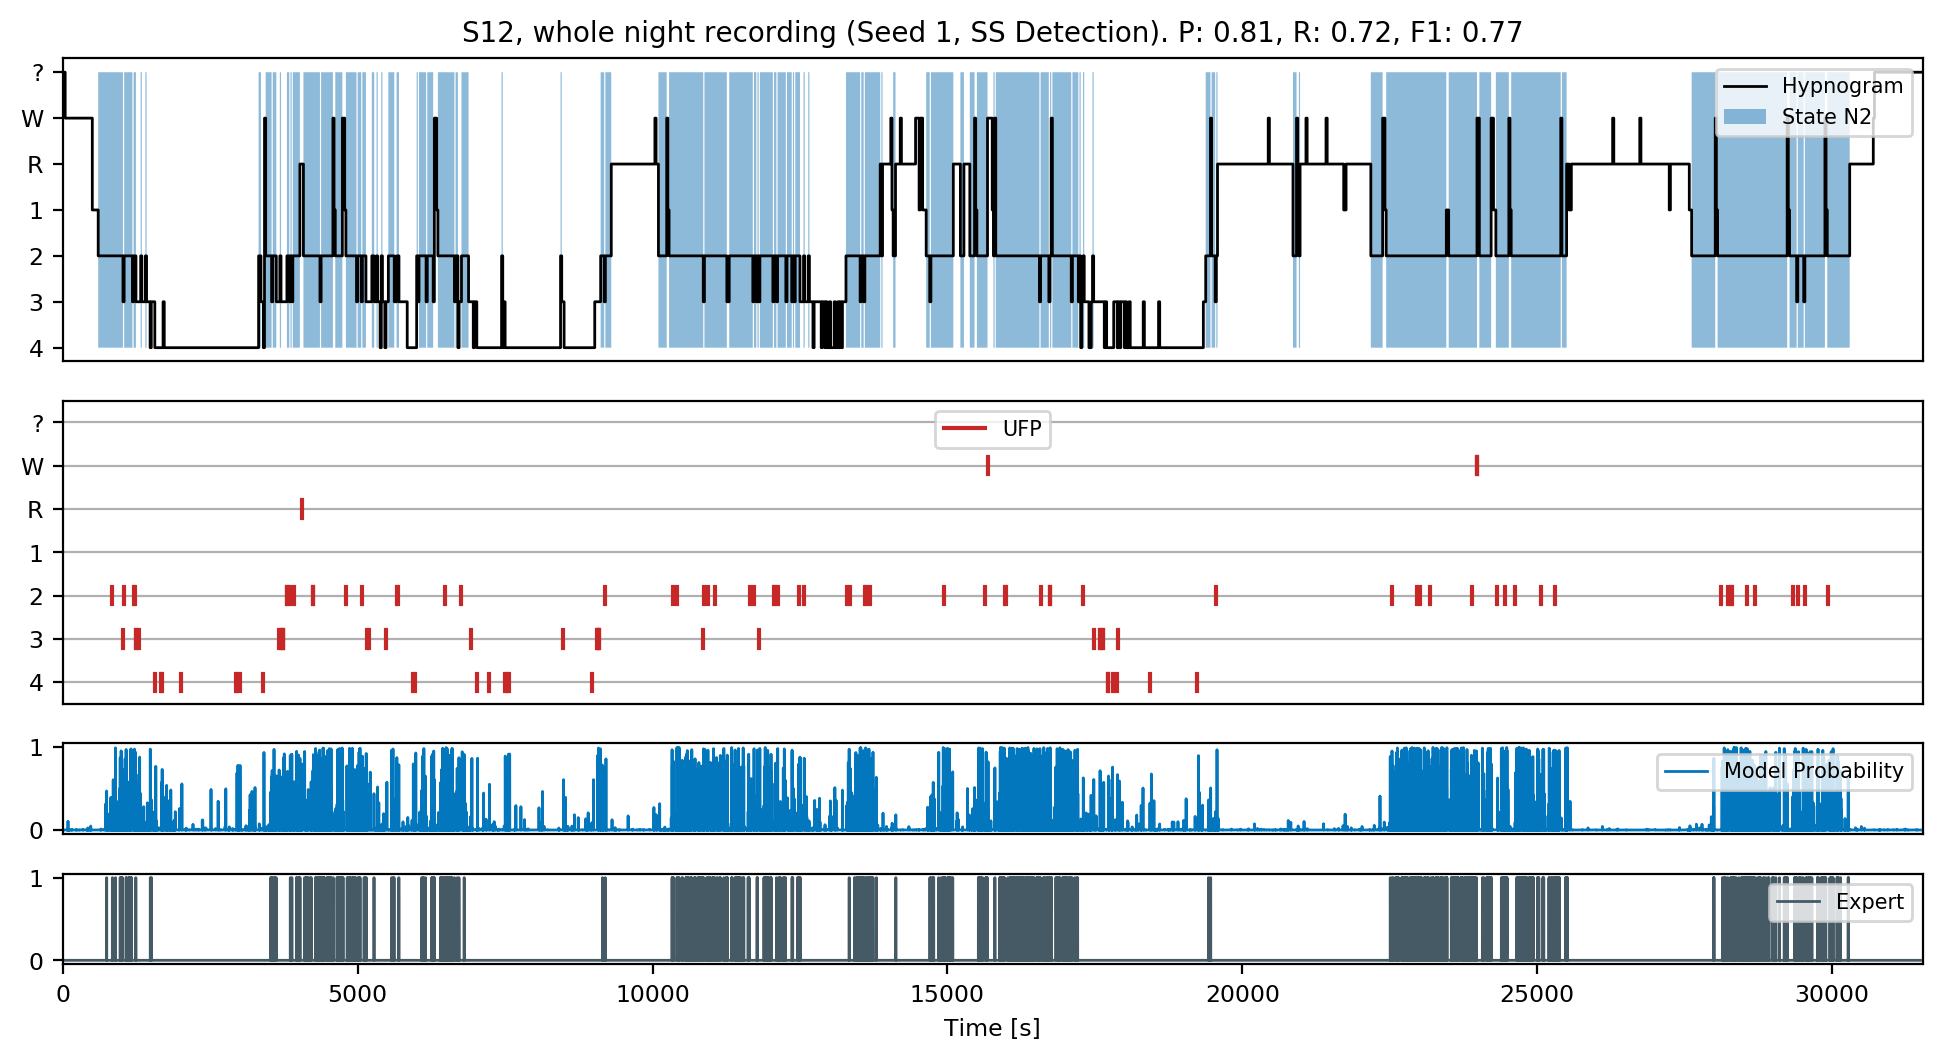


Subject ID 13
Number of events 692
Number of detections 1040
Number of matched 646
Number of UFP 394, Number of UFN 46
Recall at IoU 0.0: 0.9335260115606936
Precision at IoU 0.0: 0.6211538461538462
F1score at IoU 0.0: 0.745958429561201
F1score at IoU 0.3: 0.74364896073903
Pages of UFP: [ 111  120  125  125  128  129  130  134  139  140  140  142  142  145
  150  151  156  162  169  177  178  182  215  293  298  300  301  302
  302  308  309  311  321  343  345  351  360  363  366  367  371  373
  376  378  380  389  394  397  400  401  403  408  408  409  409  410
  412  412  417  421  423  425  431  454  470  473  474  490  490  494
  494  497  498  498  499  499  501  505  506  509  510  512  517  519
  520  522  527  528  528  532  533  535  536  537  538  539  539  541
  543  545  547  550  550  554  555  557  558  558  563  564  572  572
  600  617  623  626  626  627  628  629  630  632  633  635  637  645
  646  647  650  654  658  660  661  664  668  671  675  680  682  684
  

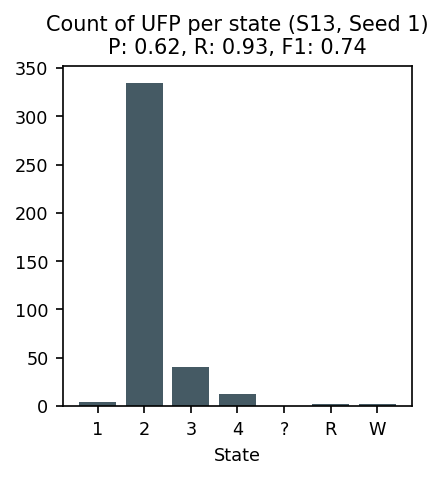

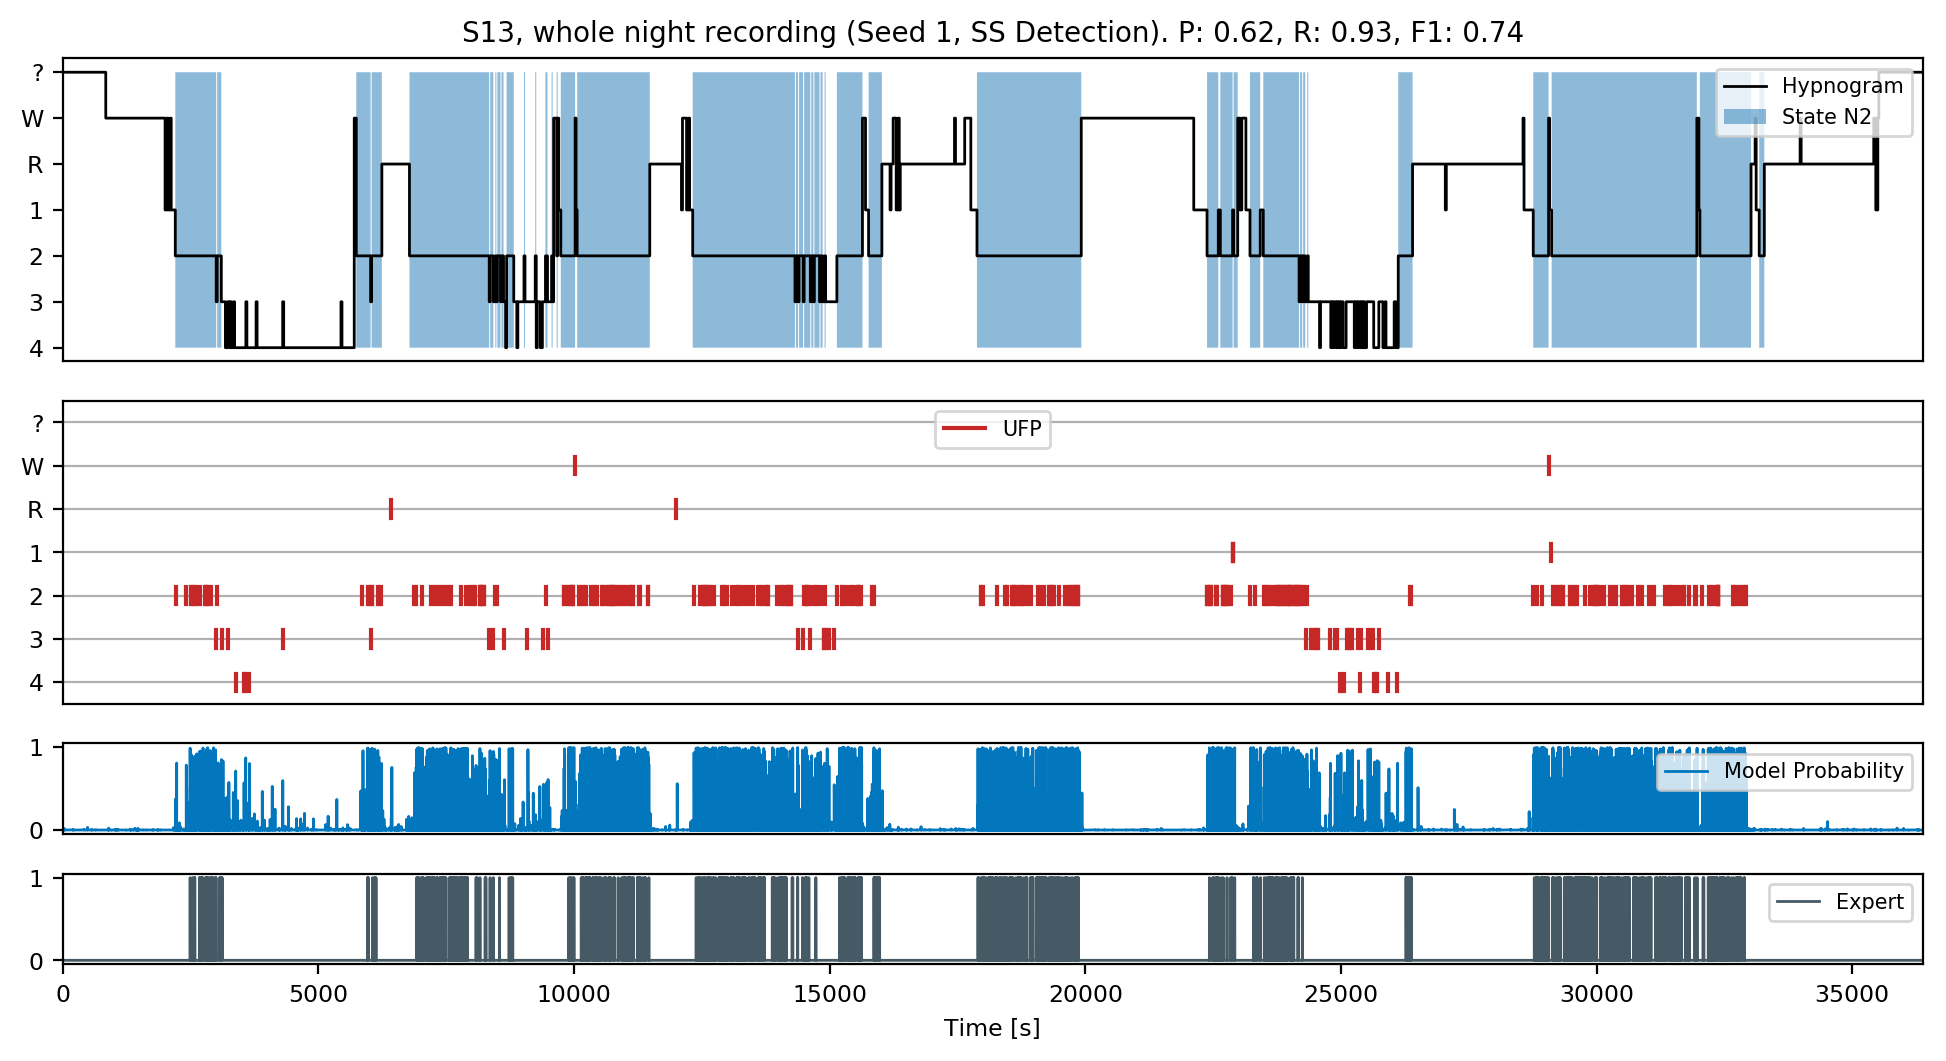

In [14]:
for sub_idx in range(len(test_ids)):

    subject_id = test_ids[sub_idx]
    print('\nSubject ID', subject_id)
    events = events_test[sub_idx]
    detections = detections_test[sub_idx]
    iou_array, idx_array = metrics.matching(events, detections)
    n_detections = detections.shape[0]
    n_events = events.shape[0]
    n_ufn = (idx_array == -1).sum()
    n_matched = n_events - n_ufn
    n_ufp = n_detections - n_matched
    n_matched_at_03 = (iou_array >= 0.3).sum()
    f1_at_03 = 2 * n_matched_at_03 / (n_events + n_detections)
    p_at_03 = n_matched_at_03 / n_detections
    r_at_03 = n_matched_at_03 / n_events
    print('Number of events', n_events)
    print('Number of detections', n_detections)
    print('Number of matched', n_matched)
    print('Number of UFP %d, Number of UFN %d' % (n_ufp, n_ufn))
    print('Recall at IoU 0.0:', n_matched / n_events)
    print('Precision at IoU 0.0:', n_matched / n_detections)
    print('F1score at IoU 0.0:', 2*n_matched / (n_events + n_detections))
    print('F1score at IoU 0.3:', f1_at_03)

    ufp_idx = [i for i in range(n_detections) if i not in idx_array]
    detections_ufp = detections[ufp_idx, :]
    centers_ufp = np.mean(detections_ufp, axis=1)
    pages_ufp = np.floor(centers_ufp / dataset.page_size).astype(np.int32)
    print('Pages of UFP:', pages_ufp)

    # Read states for subset of pages
    print('\nLoading states')
    numerical_state_values = {
        '1': -1, '2': -2, '3': -3, '4': -4, 'R': 0, 'W': 1, '?': 2
    }
    pages_subset_states = dataset.get_subject_hypnogram(subject_id)
    print('Hypnogram size', pages_subset_states.shape)

    print('Pages states unique values:', np.unique(pages_subset_states))

    # Get state of UFP
    states_ufp = pages_subset_states[pages_ufp]

    fs = dataset.fs
    down_factor = prediction_val.params[pkeys.TOTAL_DOWNSAMPLING_FACTOR]
    fs_proba = fs / down_factor
    
    # Probability
    my_proba = prediction_test.probabilities_dict[subject_id]
    my_proba_time = np.arange(my_proba.shape[0]) / fs_proba

    # Expert stamps
    my_expert = utils.stamp2seq(events, 0, my_proba.shape[0] * down_factor + 1)
    my_expert_time = np.arange(my_expert.shape[0]) / fs


    numerical_state = np.zeros(pages_subset_states.shape)
    state_time = np.arange(pages_subset_states.shape[0]) * dataset.page_duration
    all_state_key_list = dataset.state_ids
    for state_key in all_state_key_list:
        np.place(numerical_state, pages_subset_states==state_key, numerical_state_values[state_key])

    # plot
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
    ax.set_title('Count of UFP per state (S%02d, Seed %d)\nP: %1.2f, R: %1.2f, F1: %1.2f' 
                 % (subject_id, seed_id, p_at_03, r_at_03, f1_at_03), fontsize=10)
    unique, counts = np.unique(states_ufp, return_counts=True)
    for state_key in all_state_key_list:
        if state_key not in unique:
            unique = np.concatenate([unique, [state_key]])
            counts = np.concatenate([counts, [0]])
    sorted_idx = np.argsort(unique)
    unique = unique[sorted_idx]
    counts = counts[sorted_idx]
    ax.bar(unique, counts, width=0.8, bottom=None, facecolor=CUSTOM_COLOR['grey'])
    ax.set_xlabel('State', fontsize=8.5)
    ax.tick_params(labelsize=8.5)
    plt.show()

    # plot
    
    fig = plt.figure(figsize=(12, 6), dpi=200)
    gs = gridspec.GridSpec(4, 1, height_ratios=[2, 2, 0.6, 0.6])

    # Hypnogram
    ax = fig.add_subplot(gs[0])
    ax.set_title('S%02d, whole night recording (Seed %d, %s Detection). P: %1.2f, R: %1.2f, F1: %1.2f' 
                 % (subject_id, seed_id, dataset_name[-2:].upper(), p_at_03, r_at_03, f1_at_03), fontsize=10)
    
    tmp_state_time = []
    tmp_numerical_state = []
    for j in range(state_time.shape[0]):
        tmp_numerical_state.append(numerical_state[j])
        tmp_numerical_state.append(numerical_state[j])
        tmp_state_time.append(state_time[j])
        tmp_state_time.append(state_time[j] + dataset.page_duration)
    tmp_state_time = np.asarray(tmp_state_time)
    tmp_numerical_state = np.asarray(tmp_numerical_state)
    
    max_time = np.max([my_expert_time[-1], my_proba_time[-1], tmp_state_time[-1]])

    ax.plot(tmp_state_time, tmp_numerical_state, color='k', zorder=2, linewidth=1, label='Hypnogram')
    ax.fill_between(tmp_state_time, 6 * (tmp_numerical_state==-2).astype(int) - 4, -4, alpha=0.5, zorder=1, label='State N2')
    ax.set_yticks([numerical_state_values[my_key] for my_key in numerical_state_values.keys()])
    ax.set_xlim([0, state_time[-1]])
    ax.set_yticklabels(list(numerical_state_values.keys()))
    ax.legend(loc='upper right', fontsize=7.5)
    ax.set_xticks([])
    ax.set_xlim([0, max_time])
    ax.tick_params(labelsize=8.5)

    # detailed UFP
    ax = fig.add_subplot(gs[1])
    ax.set_ylim([-4.5, 2.5])
    ax.set_xticks([])
    ax.set_xlim([0, max_time])
    ax.set_yticks([numerical_state_values[my_key] for my_key in numerical_state_values.keys()])
    ax.set_yticklabels(list(numerical_state_values.keys()))
    label_set = False
    for j, state_key in enumerate(all_state_key_list):
        for k, page in enumerate(pages_ufp):
            if states_ufp[k] == state_key:
                if label_set:
                    label = None
                else:
                    label = 'UFP'
                label_set = True
                page_time = page * dataset.page_duration
                ax.plot(
                    [page_time, page_time], 
                    [numerical_state_values[state_key] - 0.2, numerical_state_values[state_key] + 0.2], 
                    color=CUSTOM_COLOR['red'], label=label, linewidth=1.5)
    if label_set:
        ax.legend(loc='upper center', fontsize=7.5)
    ax.yaxis.grid()
    ax.tick_params(labelsize=8.5)

    # Model probability
    ax = fig.add_subplot(gs[2])
    ax.plot(my_proba_time, my_proba, label='Model Probability',color=CUSTOM_COLOR['blue'], linewidth=1)
    ax.set_yticks([0, 1])
    ax.legend(loc='upper right', fontsize=7.5)
    ax.set_xticks([])
    ax.set_xlim([0, max_time])
    ax.tick_params(labelsize=8.5)

    # Expert stamps
    ax = fig.add_subplot(gs[3])
    ax.plot(my_expert_time, my_expert, label='Expert',color=CUSTOM_COLOR['grey'], linewidth=1)
    ax.set_yticks([0, 1])
    ax.legend(loc='upper right', fontsize=7.5)
    ax.set_xlim([0, max_time])
    ax.tick_params(labelsize=8.5)
    ax.set_xlabel('Time [s]', fontsize=8.5)

    plt.show()